# Periods GAIA, ZTF, PanSTARRS, DES compared to Rubin (Doug)

Overall goal: Compare periods from periodic objects found in other surveys to Rubin ComCam data

Compare periodicity of objects we found with other surveys. We can use this for validation and interesting science.  This is a similar project as project 4, but with swapped starting and ending catalog.

1. Take all objects that you can find in GAIA or ZTF or  PanSTARRS or DES that are in the area that Comcam has covered. Start with one survey first, and expand to other surveys after your completed points below. GAIA has periods provided so it might be a good first choice.
2. Find any object you can for which period is computed. Run LombScargle algorithm on the lightcurves from these non-Rubin surveys. If a period is provided, limit the period search to the range of [catalog_period - 10%, catalog_period + 10%]
3. Find the most interesting objects, and run the same/similar algorithm on Rubin lightcurves. 
4. Compare the results, i.e., are you finding similar numbers in non-Rubin and rubin lightcurve. Are there objects that have changed their period.


In [40]:
pip install lsdb light_curve

Defaulting to user installation because normal site-packages is not writeable
  Using cached light_curve-0.10.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (36 kB)
Using cached light_curve-0.10.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import lsdb
from nested_pandas.series.dtype import NestedDtype
import pandas as pd
import dask.dataframe as dd
print(lsdb.__version__)

In [3]:
from dask.distributed import Client

client = Client(n_workers=2, memory_limit="20GB")

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-686954' coro=<Client._gather.<locals>.wait() done, defined at /sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-694289' coro=<Client._gather.<locals>.wait() done, defined at /sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit


## Find Set of Truth Variable Objects & Periods From Gaia DR3
Live in separate variability tables: https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_variability_tables/

Bulk downloads available here: https://cdn.gea.esac.esa.int/Gaia/gdr3/Variability/

1. Find which variability tables have periods, probably need to pull in a few
2. Load in the relevant tables, hats import them?
3. Cross match these tables to Comcam to get the relevant subset, may need to join through gaia_dr3 first to get ra and dec
4. Do any needed filtering to get towards periods

In [4]:
#gaia_dr3 = lsdb.read_hats('https://data.lsdb.io/hats/gaia_dr3/gaia', margin_cache='https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs', columns="all")
#gaia_dr3#["phot_variable_flag"]
# Columns to use phot_variable_flag

### Build a composite variability table from Gaia DR3 Tables

In [36]:
# Use a universal set of columns
shared_cols = ["Source", "SolID","RA_ICRS", "DE_ICRS", "PF", "P1O"]

#Gaia RRLyrae Catalog - 271779 rows
# https://tapvizier.cds.unistra.fr/adql/?%20I/358/vrrlyr
rrlyr_df = pd.read_csv("/sdf/home/b/brantd/gaia_dr3_rrlyrae_period.csv")[shared_cols]
rrlyr_df["provenance"] = "vari_rrlyr"

# Gaia Variable Cepheid Catalog - 15021 rows
# https://tapvizier.cds.unistra.fr/adql/?%20I/358/scalerts%20I/358/alertsms%20I/358/varisum%20I/358/vclassre%20I/358/vcclassd%20I/358/vagn%20I/358/vcep%20I/358/vceph%20I/358/vcc%20I/358/veb%20I/358/veprv%20I/358/vrvstat%20I/358/vlpv%20I/358/vmicro%20I/358/vmsosc%20I/358/vrm%20I/358/vrmo%20I/358/vrms%20I/358/vpltrans%20I/358/vrrlyr%20I/358/vrrlyrh%20I/358/vst
vcep_df = pd.read_csv("/sdf/home/b/brantd/gaia_dr3_vcep.csv")[shared_cols]
vcep_df["provenance"] = "vari_vcep"

# Compact Companion Candidates - 6306 rows (not enough to be worth adding)

# Eclipsing Binary Candidates - 2184477 rows, but not a clear "period" column
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/358/veb&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa

vari_df = pd.concat([rrlyr_df, vcep_df])
vari_df

,Source,SolID,RA_ICRS,DE_ICRS,PF,P1O,provenance
0,1000146253713924352,375316653866487565,103.134722,56.122426,NaN,0.313748,vari_rrlyr
1,1000148246578725632,375316653866487565,102.900343,56.093749,NaN,0.360003,vari_rrlyr
...,...,...,...,...,...,...,...
15019,898874021546560384,375316653866487564,111.608525,37.457896,3.228622,NaN,vari_vcep
15020,958623063948528896,375316653866487564,96.576608,42.698921,1.669935,NaN,vari_vcep


In [49]:
# Convert to catalog
vari_cat = lsdb.from_dataframe(vari_df, ra_column="RA_ICRS", dec_column="DE_ICRS", catalog_name="gaia_vari")
vari_cat

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 19.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


KeyboardInterrupt: 

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - gaia_vari'}>)

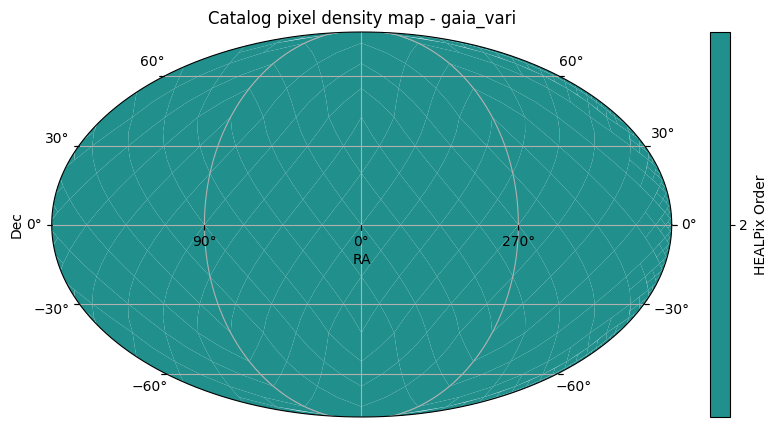

In [47]:
vari_cat.plot_pixels()

### Question: How much total overlap is there between Gaia DR3 and Comcam?

In [5]:
gaia_dr3 = lsdb.read_hats('https://data.lsdb.io/hats/gaia_dr3/gaia', 
                          margin_cache='https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs', 
                          columns=["solution_id","ra", "dec"]) # trimming columns is neccesary for memory management
comcam = lsdb.read_hats("/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc",
                        margin_cache='/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_5arcs',
                        columns=["diaObjectId","ra", "dec"])

                    
cc_x_gdr3 = comcam.crossmatch(gaia_dr3)
#len(cc_x_gdr3._ddf) # 327327

327327

## Calculate LombScargle Periods For Non-Rubin Lightcurves
ZTF to start, PS1, DESC after

### ZTF

/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


53011

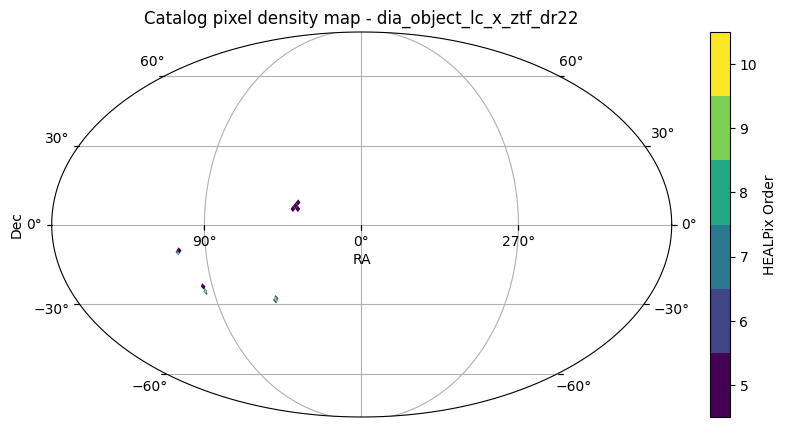

In [38]:
ztf_cat = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_x_ztf_dr22')

# Assign NestedDtypes
ztf_cat._ddf = ztf_cat._ddf.astype({"diaSource":NestedDtype(ztf_cat.dtypes["diaSource"].pyarrow_dtype),
                                    "diaObjectForcedSource":NestedDtype(ztf_cat.dtypes["diaObjectForcedSource"].pyarrow_dtype),
                                    "ztf_lc":NestedDtype(ztf_cat.dtypes["ztf_lc"].pyarrow_dtype)})


ztf_cat.plot_pixels()
len(ztf_cat)

/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - dia_object_lc_x_ztf_dr22_x_gaia_vari'}>)

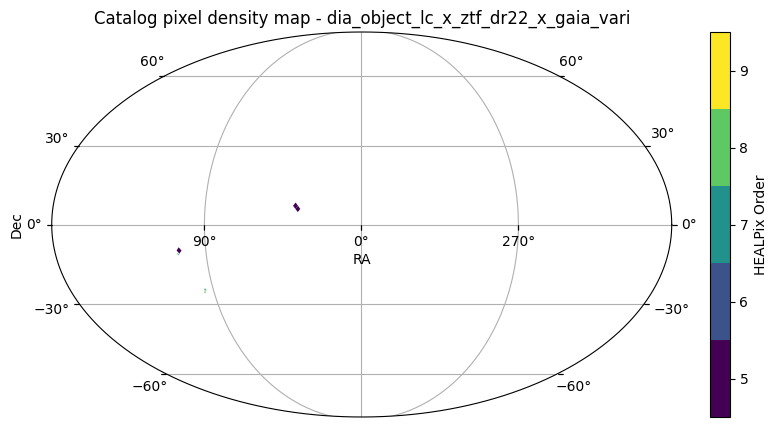

In [40]:
ztf_vari = ztf_cat.crossmatch(vari_cat)
ztf_vari.plot_pixels()

In [43]:
# Very small -> Go to nested-pandas
vari_ndf = ztf_vari.compute().dropna(subset=["PF_gaia_vari"]).query("nDiaSources_dia_object_lc_x_ztf_dr22>10")
vari_ndf

diaObjectId_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                      4602538081684291611   
1456169048697174952                   2430571608268603427   
1456180540012683497                   2430096619245404295   
1456195138833230598                   2430615588733714511   

                     ra_dia_object_lc_x_ztf_dr22  \
_healpix_29                                        
9697289099026113                       38.601798   
1456169048697174952                    94.997241   
1456180540012683497                    94.790827   
1456195138833230598                    95.013513   

                     dec_dia_object_lc_x_ztf_dr22  \
_healpix_29                                         
9697289099026113                         7.393511   
1456169048697174952                    -24.689506   
1456180540012683497                    -24.681146   
1456195138833230598                    -24.443534   

                     nDiaSources_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                                       20   
1456169048697174952                                   132   
1456180540012683497                                    74   
1456195138833230598                                    11   

                     radecMjdTai_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                             60652.095275   
1456169048697174952                          60656.341488   
1456180540012683497                          60656.341913   
1456195138833230598                          60656.339882   

                     tract_dia_object_lc_x_ztf_dr22  \
_healpix_29                                           
9697289099026113                              10464   
1456169048697174952                            5526   
1456180540012683497                            5525   
1456195138833230598                            5526   

                                    diaSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{visit: 2024112300216, detector: 5, band: 'r'...   
1456169048697174952  [{visit: 2024111900358, detector: 2, band: 'y'...   
1456180540012683497  [{visit: 2024111900368, detector: 2, band: 'i'...   
1456195138833230598  [{visit: 2024111900364, detector: 2, band: 'y'...   

                        diaObjectForcedSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{parentObjectId: 0, coord_ra: 38.601798, coor...   
1456169048697174952  [{parentObjectId: 0, coord_ra: 94.997241, coor...   
1456180540012683497  [{parentObjectId: 0, coord_ra: 94.790827, coor...   
1456195138833230598  [{parentObjectId: 0, coord_ra: 95.013513, coor...   

                                       ztf_lc_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{objectid_ztf: 452315300000050, filterid_ztf:...   
1456169048697174952  [{objectid_ztf: 258208100005707, filterid_ztf:...   
1456180540012683497  [{objectid_ztf: 258208100015250, filterid_ztf:...   
1456195138833230598  [{objectid_ztf: 258208100001880, filterid_ztf:...   

                        Source_gaia_vari     SolID_gaia_vari  \
_healpix_29                                                    
9697289099026113       19394560480631168  375316653866487565   
1456169048697174952  2912338089863209728  375316653866487565   
1456180540012683497  2912361076526273664  375316653866487565   
1456195138833230598  2912390252242869504  375316653866487565   

                     RA_ICRS_gaia_vari  DE_ICRS_gaia_vari  PF_gaia_vari  \
_healpix_29                                                               
9697289099026113             38.601791           7.393524      0.619628   
145616904869

In [10]:
#rrlyr_ndf["ztf_lc_dia_object_lc_x_ztf_dr22"].nest.fields

In [11]:
import light_curve as licu
import numpy as np

extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        #nyquist=0.5, # this seems to hang the run
        max_freq_factor=30, # Currently 1.0 for fast runs, will raise for more interesting graphs later
        fast=False,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
)


# light-curve requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def extract_features(mjd, mag, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float32)

    # Filter any infinite mags (fluxes here)
    t = t[np.isfinite(mag)]
    mag = mag[np.isfinite(mag)]

    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


features = rrlyr_ndf.reduce(
    extract_features,
    "ztf_lc_dia_object_lc_x_ztf_dr22.hmjd_ztf",
    "ztf_lc_dia_object_lc_x_ztf_dr22.mag_ztf",
    #meta={name: np.float32 for name in extractor.names},
)

rrlyr_ndf.join(features)[["PF_gaia_rrlyrae","period_0", "period_s_to_n_0"]]

,PF_gaia_rrlyrae,period_0,period_s_to_n_0
_healpix_29,,,
9697289099026113,0.619628,7.798786,4.765861
1456169048697174952,0.586757,4.000662,4.228000
1456180540012683497,0.636939,1.980331,3.234780
1456195138833230598,0.766476,19.892876,4.531097


### Panstarrs

In [12]:
ps1 = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_x_ps1')
ps1

,diaObjectId,ra,dec,nDiaSources,radecMjdTai,tract,diaSource,diaObjectForcedSource,objName_ps1,objNameHMS_ps1,objAltName1_ps1,objAltName2_ps1,objAltName3_ps1,objPopularName_ps1,objID_ps1,uniquePspsOBid_ps1,ippObjID_ps1,surveyID_ps1,htmID_ps1,zoneID_ps1,tessID_ps1,projectionID_ps1,skyCellID_ps1,randomID_ps1,batchID_ps1,dvoRegionID_ps1,processingVersion_ps1,objInfoFlag_ps1,astrometryCorrectionFlag_ps1,qualityFlag_ps1,raStack_ps1,decStack_ps1,raStackErr_ps1,decStackErr_ps1,raMean_ps1,decMean_ps1,raMeanErr_ps1,decMeanErr_ps1,pmra_ps1,pmdec_ps1,pmraErr_ps1,pmdecErr_ps1,epochMean_ps1,posMeanChisq_ps1,cx_ps1,cy_ps1,cz_ps1,lambda_ps1,beta_ps1,l_ps1,b_ps1,nStackObjectRows_ps1,nStackDetections_ps1,nDetections_ps1,ng_ps1,nr_ps1,ni_ps1,nz_ps1,ny_ps1,gQfPerfect_ps1,gMeanPSFMag_ps1,gMeanPSFMagErr_ps1,gMeanPSFMagStd_ps1,gMeanPSFMagNpt_ps1,gMeanPSFMagMin_ps1,gMeanPSFMagMax_ps1,gMeanKronMag_ps1,gMeanKronMagErr_ps1,gMeanKronMagStd_ps1,gMeanKronMagNpt_ps1,gMeanApMag_ps1,gMeanApMagErr_ps1,gMeanApMagStd_ps1,gMeanApMagNpt_ps1,gFlags_ps1,rQfPerfect_ps1,rMeanPSFMag_ps1,rMeanPSFMagErr_ps1,rMeanPSFMagStd_ps1,rMeanPSFMagNpt_ps1,rMeanPSFMagMin_ps1,rMeanPSFMagMax_ps1,rMeanKronMag_ps1,rMeanKronMagErr_ps1,rMeanKronMagStd_ps1,rMeanKronMagNpt_ps1,rMeanApMag_ps1,rMeanApMagErr_ps1,rMeanApMagStd_ps1,rMeanApMagNpt_ps1,rFlags_ps1,iQfPerfect_ps1,iMeanPSFMag_ps1,iMeanPSFMagErr_ps1,iMeanPSFMagStd_ps1,iMeanPSFMagNpt_ps1,iMeanPSFMagMin_ps1,iMeanPSFMagMax_ps1,iMeanKronMag_ps1,iMeanKronMagErr_ps1,iMeanKronMagStd_ps1,iMeanKronMagNpt_ps1,iMeanApMag_ps1,iMeanApMagErr_ps1,iMeanApMagStd_ps1,iMeanApMagNpt_ps1,iFlags_ps1,zQfPerfect_ps1,zMeanPSFMag_ps1,zMeanPSFMagErr_ps1,zMeanPSFMagStd_ps1,zMeanPSFMagNpt_ps1,zMeanPSFMagMin_ps1,zMeanPSFMagMax_ps1,zMeanKronMag_ps1,zMeanKronMagErr_ps1,zMeanKronMagStd_ps1,zMeanKronMagNpt_ps1,zMeanApMag_ps1,zMeanApMagErr_ps1,zMeanApMagStd_ps1,zMeanApMagNpt_ps1,zFlags_ps1,yQfPerfect_ps1,yMeanPSFMag_ps1,yMeanPSFMagErr_ps1,yMeanPSFMagStd_ps1,yMeanPSFMagNpt_ps1,yMeanPSFMagMin_ps1,yMeanPSFMagMax_ps1,yMeanKronMag_ps1,yMeanKronMagErr_ps1,yMeanKronMagStd_ps1,yMeanKronMagNpt_ps1,yMeanApMag_ps1,yMeanApMagErr_ps1,yMeanApMagStd_ps1,yMeanApMagNpt_ps1,yFlags_ps1,lsst_ztf_sep,Norder,Dir,Npix
npartitions=206,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 6, Pixel: 130",int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],int64[pyarrow],"struct<visit: list<element: int64>, detector: ...","struct<parentObjectId: list<element: int64>, c...",string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int16[pyarrow],int64[pyarrow],int32[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],double[pyarrow],int64[pyarrow],int32[pyarrow],int16[pyarrow],int32[pyarrow],int32[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double

## Calculate LombScargle Periods for matched Rubin Lightcurves
Plot differences in periods per object

In [13]:
#rrlyr_ndf["diaSource_dia_object_lc_x_ztf_dr22"].nest.fields

In [14]:
import light_curve as licu
import numpy as np

extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        #nyquist=0.5, # this seems to hang the run
        max_freq_factor=30, # Currently 1.0 for fast runs, will raise for more interesting graphs later
        fast=False,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
)


# light-curve requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def extract_features(mjd, mag, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float64)

    # Filter any infinite mags (fluxes here)
    t = t[np.isfinite(mag)]
    mag = mag[np.isfinite(mag)]

    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


features = rrlyr_ndf.reduce(
    extract_features,
    "diaSource_dia_object_lc_x_ztf_dr22.midpointMjdTai",
    "diaSource_dia_object_lc_x_ztf_dr22.psfMag",
    #meta={name: np.float32 for name in extractor.names},
)

rrlyr_ndf.join(features)[["PF_gaia_rrlyrae","period_0", "period_s_to_n_0"]]

,PF_gaia_rrlyrae,period_0,period_s_to_n_0
_healpix_29,,,
9697289099026113,0.619628,0.983600,1.563312
1456169048697174952,0.586757,0.031894,5.501743
1456180540012683497,0.636939,0.201770,1.964900
1456195138833230598,0.766476,0.397988,2.383210


/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - dia_object_lc'}>)

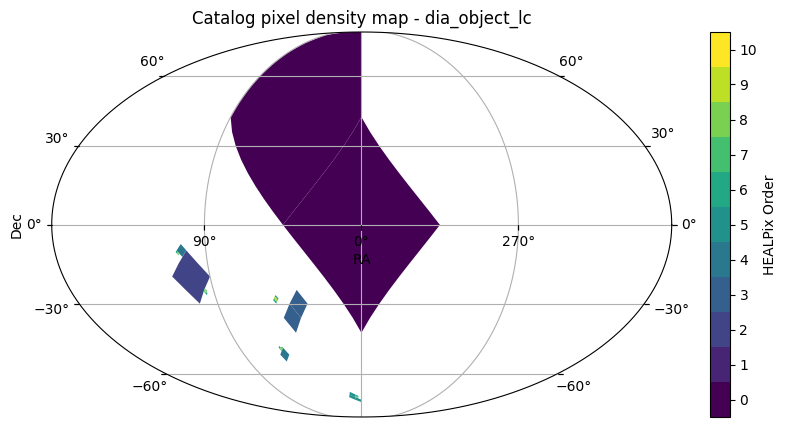

In [15]:
comcam_cat = lsdb.read_hats("/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc")

# Assign NestedDtypes
comcam_cat._ddf = comcam_cat._ddf.astype({"diaSource":NestedDtype(comcam_cat.dtypes["diaSource"].pyarrow_dtype),
                                          "diaObjectForcedSource":NestedDtype(comcam_cat.dtypes["diaObjectForcedSource"].pyarrow_dtype)})

comcam_cat.plot_pixels()

/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - dia_object_lc_x_gaia_rrlyrae'}>)

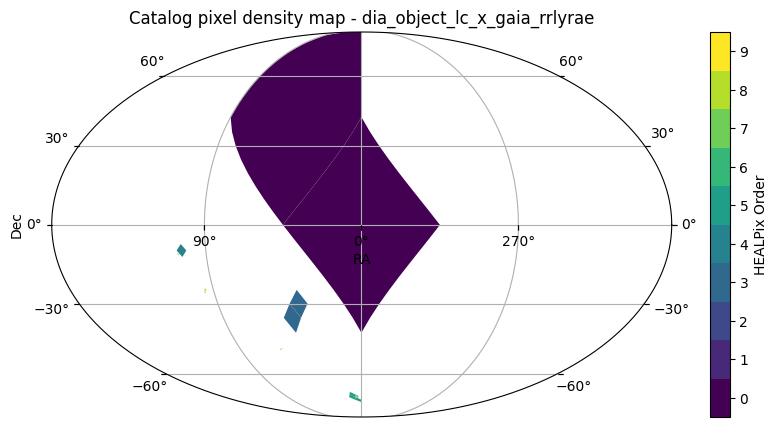

In [16]:
comcam_rrlyr = comcam_cat.crossmatch(rrlyr_cat)
comcam_rrlyr.plot_pixels()

In [17]:
from nested_pandas.utils import count_nested
cc_rrl_ndf = comcam_rrlyr.compute().query("diaSource_dia_object_lc.band == 'g'").dropna(subset=["diaSource_dia_object_lc"])
cc_rrl_ndf = count_nested(cc_rrl_ndf, "diaSource_dia_object_lc").dropna(subset=["diaSource_dia_object_lc"]).query("n_diaSource_dia_object_lc > 30")
cc_rrl_ndf

diaObjectId_dia_object_lc  ra_dia_object_lc  \
_healpix_29                                                        
1456145241764177783        2430479249291870271         95.124187   
1456169048697174952        2430571608268603427         94.997241   
2415759959093350605        1053006683967586331         58.835044   

                     dec_dia_object_lc  nDiaSources_dia_object_lc  \
_healpix_29                                                         
1456145241764177783         -25.043292                        164   
1456169048697174952         -24.689506                        132   
2415759959093350605         -48.791217                        200   

                     radecMjdTai_dia_object_lc  tract_dia_object_lc  \
_healpix_29                                                           
1456145241764177783               60656.341097                 5526   
1456169048697174952               60656.341488                 5526   
2415759959093350605               60655.279809                 2394   

                                               diaSource_dia_object_lc  \
_healpix_29                                                              
1456145241764177783  [{visit: 2024112600309, detector: 4, band: 'g'...   
1456169048697174952  [{visit: 2024120100446, detector: 2, band: 'g'...   
2415759959093350605  [{visit: 2024112600149, detector: 7, band: 'g'...   

                                   diaObjectForcedSource_dia_object_lc  \
_healpix_29                                                              
1456145241764177783  [{parentObjectId: 0, coord_ra: 95.124187, coor...   
1456169048697174952  [{parentObjectId: 0, coord_ra: 94.997241, coor...   
2415759959093350605  [{parentObjectId: 0, coord_ra: 58.835044, coor...   

                     Source_gaia_rrlyrae  SolID_gaia_rrlyrae  ...  \
_healpix_29                                                   ...   
1456145241764177783  2912290471563097088  375316653866487565  ...   
1456169048697174952  2912338089863209728  375316653866487565  ...   
2415759959093350605  4831519899384690944  375316653866487565  ...   

                     FundFreq1_gaia_rrlyrae  FundFreq2_gaia_rrlyrae  \
_healpix_29                                                           
1456145241764177783                 4.24325                    <NA>   
1456169048697174952                1.704284                    <NA>   
2415759959093350605                1.768699                    <NA>   

                     Class_gaia_rrlyrae  AG_gaia_rrlyrae  \
_healpix_29                                                
1456145241764177783                RRc              <NA>   
1456169048697174952                RRab         0.094402   
2415759959093350605                RRab        -0.090557   

                     RA_ICRS_gaia_rrlyrae  DE_ICRS_gaia_rrlyrae  \
_healpix_29                                                       
1456145241764177783             95.124187             -25.04329   
1456169048697174952             94.997236            -24.689497   
2415759959093350605             58.835053            -48.791215   

                     _RA_icrs_gaia_rrlyrae  _DE_icrs_gaia_rrlyrae  \
_healpix_29                                                         
1456145241764177783              95.124187              -25.04329   
1456169048697174952              94.997236             -24.689497   
2415759959093350605              58.835053             -48.791215   

                     _dist_arcsec  n_diaSource_dia_object_lc  
_healpix_29                                                   
1456145241764177783      0.007677                         43  
1456169048697174952      0.037207                         35  
2415759959093350605      0.022602                         45  

[3 rows x 30 columns]

In [39]:
len(rrlyr_cat)

271779